# Zadanie rekrutacyjne na stanowisko Data Science

In [42]:
# @hidden
from IPython.display import HTML
from typing import Dict, List, Optional, Any, Tuple

from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import plot_importance

%matplotlib inline

    
# Model
class XgbModel:

    def __init__(self, model_parameters: Dict):
        self.model_parameters: Dict = model_parameters
        self.model: Optional[xgb.XGBRegressor] = None

    def train(self, x_train: pd.DataFrame, y_train: pd.DataFrame, x_val: pd.DataFrame, y_val: pd.DataFrame)\
            -> xgb.XGBRegressor:
        model = self.__create_model(x_train, x_val, y_train, y_val)
        model.fit(x_train, y_train,
                  eval_set=[(x_train, y_train), (x_val, y_val)],
                  early_stopping_rounds=25,
                  verbose=True)
        self.model = model

        return model

    def predict(self, df: pd.DataFrame) -> np.ndarray:
        prediction = self.model.predict(df)
        prediction[prediction < 0] = 0

        return prediction

    def __create_model(self, x_train: pd.DataFrame, x_val: pd.DataFrame, y_train: pd.DataFrame, y_val: pd.DataFrame) \
            -> xgb.XGBRegressor:
        if self.model_parameters:
            return xgb.XGBRegressor(**self.model_parameters)
        else:
            return xgb.XGBRegressor(**XgbModel.__find_best_parameters(x_train, x_val, y_train, y_val))
    
    def plot_model_importance()-> None:
        xgb.plot_importance(self.model)

    @staticmethod
    def __find_best_parameters(x_train: pd.DataFrame, x_val: pd.DataFrame, y_train: pd.DataFrame, y_val: pd.DataFrame) \
            -> Dict:

        xg_train = xgb.DMatrix(x_train, label=y_train)
        xg_val = xgb.DMatrix(x_val, label=y_val)

        def model_bayesian(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, alpha):
            max_depth = int(max_depth)
            min_child_weight = int(min_child_weight)
            training_params = {
                'n_jobs': -1,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'min_child_weight': min_child_weight,
                'subsample': subsample,
                'colsample_bytree': colsample_bytree,
                'alpha': alpha,
                'max_bin': 63,
                'objective': 'reg:squarederror',
                'verbosity': 0,
                'silent': True}
            clf = xgb.train(training_params, xg_train)
            score = mean_squared_error(xg_val.get_label(), clf.predict(xg_val))

            return -1.0 * score

        parameters_bounds = {
            'learning_rate': (0.001, 0.3),
            'max_depth': (2, 24),
            'min_child_weight': (1, 25),
            'subsample': (0.1, 0.9),
            'colsample_bytree': (0.1, 0.9),
            'alpha': (1e-5, 100),
        }

        optimized_model = BayesianOptimization(model_bayesian, parameters_bounds, random_state=13)
        init_points, n_iter = 25, 1

        optimized_model.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
        parameters = XgbModel.__get_parameters(optimized_model)
        print(f'Best parameters {str(XgbModel.__name__)}: {parameters}')

        return parameters

    @staticmethod
    def __get_parameters(optimized_model: BayesianOptimization) -> Dict:

        parameters = {
            'min_child_weight': int(optimized_model.max['params']['min_child_weight']),
            'subsample': optimized_model.max['params']['subsample'],
            'colsample_bytree': optimized_model.max['params']['colsample_bytree'],
            'max_bin': 63,
            'objective': 'count:poisson',
            'verbosity': 0,
            'silent': True,
            'metric': 'rmse',
            'is_unbalance': False,
            'learning_rate': optimized_model.max['params']['learning_rate'],
            'max_depth': int(optimized_model.max['params']['max_depth']),
            'save_binary': True,
            'seed': 1337,
            'alpha': optimized_model.max['params']['alpha'],
        }

        return parameters
    
# Funkcje
def load_df(path: str) -> pd.DataFrame:
    df = pd.read_csv(f'./{path}')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    df = df.sort_index()
    
    return df

def get_lags_columns(df: pd.DataFrame, columns: List, lag: int) -> pd.DataFrame:
    assert lag >= 1, 'Lag value must by more than 1!'
    for shift in range(1, lag):
        shift_df = df[columns].shift(shift)
        shift_df.columns = [f'{col}_{shift}__shift' for col in shift_df.columns]
        df = pd.merge(df, shift_df, left_index=True, right_index=True, how='left')
    
    return df

def get_moving_avreage_columns(df: pd.DataFrame, columns: List[str], windows: List[int]) -> pd.DataFrame:
    for window in windows:
        moving_avreage=df[columns].rolling(window=window).mean()
        moving_avreage.columns = [f'{col}_{window}_mean' for col in moving_avreage.columns]
        df = pd.merge(df, moving_avreage, left_index=True, right_index=True, how='left')

    return df

def remove_by_treshlod_with_fill(df: pd.DataFrame, cols: List[str], treshlod: int) -> pd.DataFrame:
    for col in cols:
        df[col] = np.where(df[col] < treshlod, np.nan, df[col])
        df[col] = df[col].interpolate(method ='linear', limit_direction ='forward')
        
    return df

def split_data(dataset: pd.DataFrame, split_time: str, target: str = 'target', val_spit: bool = True):
    train, test = dataset[:split_time], dataset[split_time:]
    x_cv, y_cv = train.drop(target, axis=1), train[[target]]
    x_test, y_test = test.drop(target, axis=1), test[[target]]
    if val_spit:
        x_train, x_val, y_train, y_val = train_test_split(x_cv, y_cv, test_size=0.2, random_state=42, shuffle=False)
        x_train, y_train = shuffle(x_train, y_train)

        return x_train, x_val, y_train, y_val, x_test, y_test

    x_cv, y_cv = shuffle(x_cv, y_cv)

    return x_cv, y_cv, x_test, y_test

def print_horizontally(series: pd.Series, index_name: str) -> None:
    nan = pd.DataFrame(series)
    nan.columns = [index_name]
    print(nan.T)
    
def calculate_metrics(target: np.ndarray, prediction: np.ndarray) -> dict:
    MSE = mean_squared_error(target, prediction)
    MAE = mean_absolute_error(target, prediction)
    R2 = r2_score(target, prediction)
    MAPE = mean_absolute_percentage_error(target, prediction)
    print('MSE: ', np.round(MSE, 2))
    print('MAE: ', np.round(MAE, 2))
    print('R-Squared: ', np.round(R2, 3))
    print('MAPE: ', np.round(MAPE, 3))
    return {
        'MAE': MAE,
        'MSE': MSE,
        'R2': R2,
        'MAPE': MAPE
    }

# Funcke wykresy
def plot_continuous_features(df: pd.DataFrame, col: List[str]) -> None:
    fig, axs = plt.subplots(6, 2, figsize=(15,10))
    col_idx = 0
    for row in range(6):
        for col in range(2):
            axs[row][col].plot(df.index, df[continuous_columns[col_idx]].values)
            axs[row][col].set_ylabel(continuous_columns[col_idx])
            axs[row][col].grid(True)
            col_idx += 1
    fig.tight_layout()
    plt.title('Continuous features')
    plt.show()
    
def plot_average_power_agg(df: pd.DataFrame, agg: str) -> None:
    df_gr = df.groupby([agg])['power'].agg(['mean', 'std'])
    fig, axs = plt.subplots(len(df_gr.columns), 1, figsize=(15,10))
    for idx, col in enumerate(list(df_gr.columns)):
        axs[idx].bar(df_gr.index, df_gr[col].values)
        axs[idx].set_xlabel(f'{agg}')
        axs[idx].set_ylabel(f'power-{col}')
        axs[idx].grid(True)

    fig.tight_layout()
    plt.show()


def plot_feature_with_power(df: pd.DataFrame, feature_name: str) -> None:
    fig, ax = plt.subplots(figsize=(20,10))
    ax2 = ax.twinx()
    ln_power = ax.plot(df.index, df.power, '--b', label='Power')
    lns_temp = ax.plot(df.index, df[feature_name], label=feature_name)
    lns = ln_power + lns_temp
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.grid()
    ax.set_xlabel('Time')
    ax2.set_ylabel(feature_name)
    ax.set_ylabel('Power')
    plt.show()
    
def plot_histogram(df: pd.DataFrame) -> None:
    fig, axs = plt.subplots(3, 4, figsize=(15,10))
    col_idx = 0
    for row in range(3):
        for col in range(4):
            axs[row][col].hist(df[continuous_columns[col_idx]].values)
            axs[row][col].set_ylabel(continuous_columns[col_idx])
            axs[row][col].grid(True)
            col_idx += 1
    fig.tight_layout()
    plt.show()
    
def plot_prediction(df_true: pd.DataFrame, prediction: np.array) -> None:
    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.plot(df_true.index, df_true.target, 'b', label='True power')
    ax1.plot(df_true.index, prediction, 'r', label='Predicted power')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Power')
    plt.legend(loc=0)
    plt.show()
    
def box_plot(df: pd.DataFrame) -> None:
    fig, axs = plt.subplots(3, 4, figsize=(15,10))
    col_idx = 0
    for row in range(3):
        for col in range(4):
            axs[row][col].boxplot(df[continuous_columns[col_idx]].values)
            axs[row][col].set_ylabel(continuous_columns[col_idx])
            axs[row][col].grid(True)
            col_idx += 1
    fig.tight_layout()
    plt.show()
    
def plot_importance_features(booster: Any, figsize: Tuple, max_num_features: int, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    
    return plot_importance(booster=booster, ax=ax, max_num_features=max_num_features, **kwargs)

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Zadanie 1 - Analiza i eksploracja danych

In [2]:
df = load_df('df_task_final.csv')
display(df.head())
display(f'First index: {df.index[0]}, last_index: {df.index[-1]}, lenght: {len(df)}')

,P1,T1,T2,Ta1,Ta3,Ta4,Ta5,Ta6,Ta7,Ta8,Ta_q,v_1,power
Timestamp,,,,,,,,,,,,,
2004-02-10 00:00:00,-262.572912,611.95100,598.11930,181.534245,155.791908,"183,5510776",168.972999,187.873896,191.665459,192.628790,389.347742,low,-275.511342
2004-02-10 00:01:00,-262.502827,611.60874,597.32802,182.118922,155.203158,"184,3680832",169.471913,188.462358,192.330486,193.248012,414.523798,low,-275.519129
2004-02-10 00:02:00,-262.432774,611.26648,596.53674,183.047085,153.407394,"185,1172925",170.123189,189.107933,193.000879,194.033012,396.883613,low,-275.521336
2004-02-10 00:03:00,-262.362689,610.92736,595.74860,183.826767,154.870932,"186,0627518",171.123891,190.142222,193.977434,194.888348,383.059752,low,-275.521336
2004-02-10 00:04:00,-262.292604,610.58510,594.95732,184.579713,156.397284,"186,6565326",171.687200,190.586563,194.514055,195.600808,386.056265,low,-275.521336


'First index: 2004-02-10 00:00:00, last_index: 2004-03-02 00:00:00, lenght: 30241'

#### Sprawdzenie brakujących wartości

In [3]:
print_horizontally(df.isna().sum(), 'nan count')

           P1  T1  T2  Ta1  Ta3  Ta4  Ta5  Ta6  Ta7  Ta8  Ta_q  v_1  power
nan count  10  22   0  109   70  112   73   84   73   73    72    0      0


#### Sprawdzenie typów zmiennych

In [4]:
print_horizontally(df.dtypes, 'type')

           P1       T1       T2      Ta1      Ta3     Ta4      Ta5      Ta6  \
type  float64  float64  float64  float64  float64  object  float64  float64   

          Ta7      Ta8     Ta_q     v_1    power  
type  float64  float64  float64  object  float64  


In [5]:
# zamiana Ta4 object -> float64 
# Dla zadnia brakujące wartosci zostały wypełnione liniowo. 
# Innym podejśćiem byłoby wypełnienie ich na podstawie średniech wartości.
df['Ta4']=df['Ta4'].str.replace(',','.')
df['Ta4']=pd.to_numeric(df['Ta4'])

In [6]:
df = df.interpolate(method ='linear', limit_direction ='forward')
print_horizontally(df.isna().sum(), 'nan count')
df['v_1'] = df['v_1'].astype('category')

           P1  T1  T2  Ta1  Ta3  Ta4  Ta5  Ta6  Ta7  Ta8  Ta_q  v_1  power
nan count   0   0   0    0    0    0    0    0    0    0     0    0      0


#### Wykres zmiennej przewidywanej

<AxesSubplot:xlabel='Timestamp'>

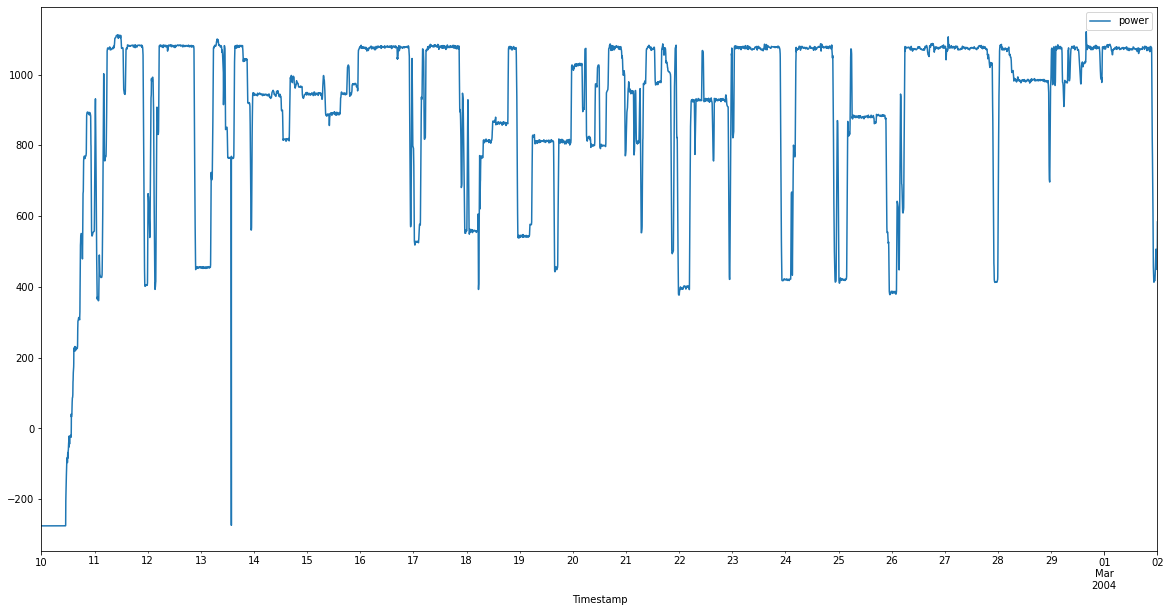

In [7]:
df.power.plot(figsize=(20,10), legend='Power')

In [8]:
# Nota: Pierwszy dzień w danych wyglądaja jak rozruchowy. 
# Zdecywałem się go odfiltrować, takie sytuacje traktuję jako anomalia. 
# W rzeczywistości skonsultowałbym takie pomiary z osobą znającą te pomiary i zestawił z oczekiwaniami predykcji.
df = df[df.index > '2004-02-11 00:00:00']
continuous_columns  = ['P1', 'T1', 'T2', 'Ta1', 'Ta3', 'Ta4', 'Ta5', 'Ta6', 'Ta7', 'Ta8', 'Ta_q', 'power']

#### Wykres wszystkim zmiennych numerycznych

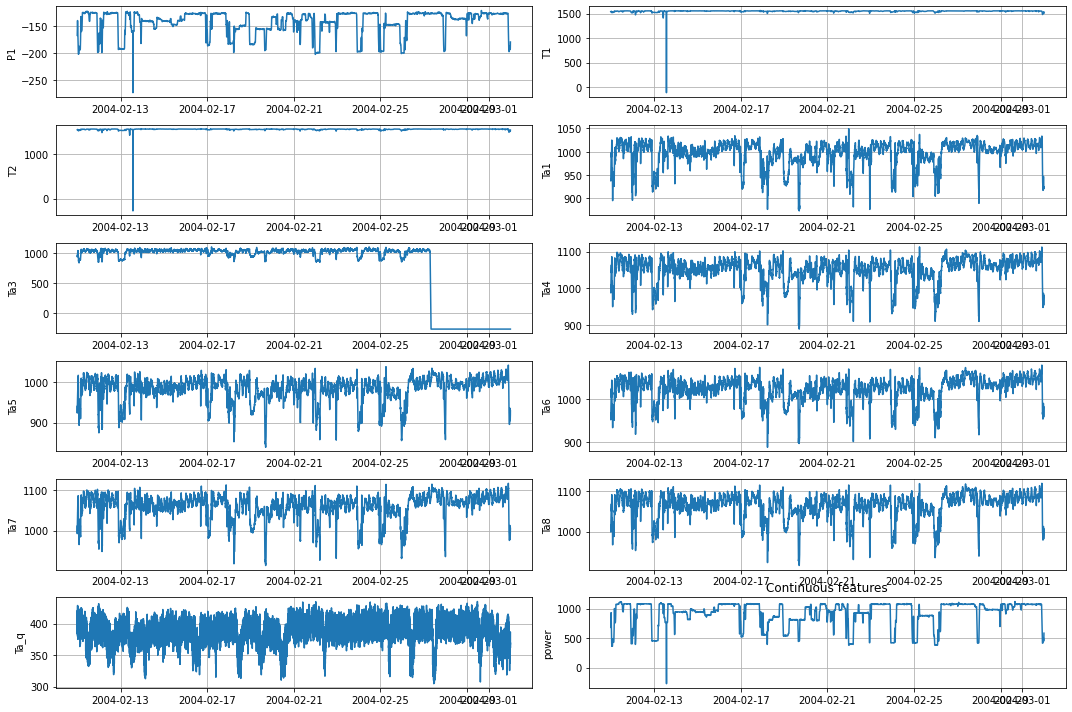

In [9]:
plot_continuous_features(df, continuous_columns)

In [10]:
# Usunięcie wartości odstających 
df = remove_by_treshlod_with_fill(df, ['T2', 'T1', 'power'], 0)
df = remove_by_treshlod_with_fill(df, ['T2', 'T1'], 1450)

#### Wykres wszystkim zmiennych numerycznych

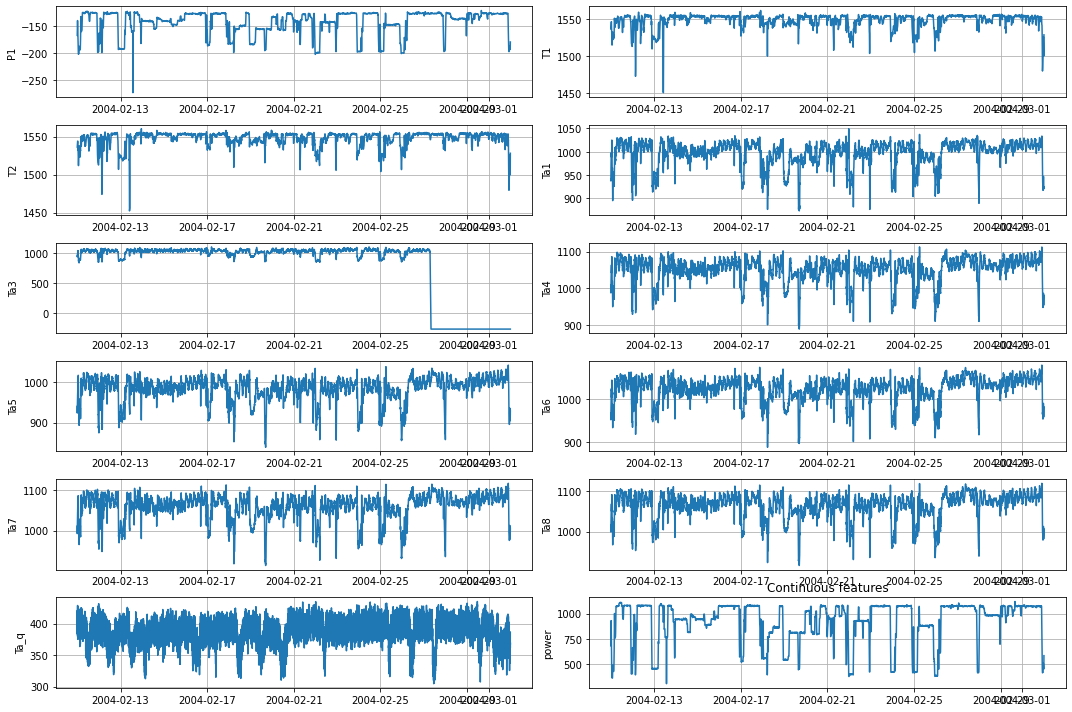

In [11]:
plot_continuous_features(df, continuous_columns)

In [12]:
# Dodanie kolumn w celu analizi
df['hour'] = df.index.hour
df['day'] = df.index.dayofweek

#### Średnia moc w dniach

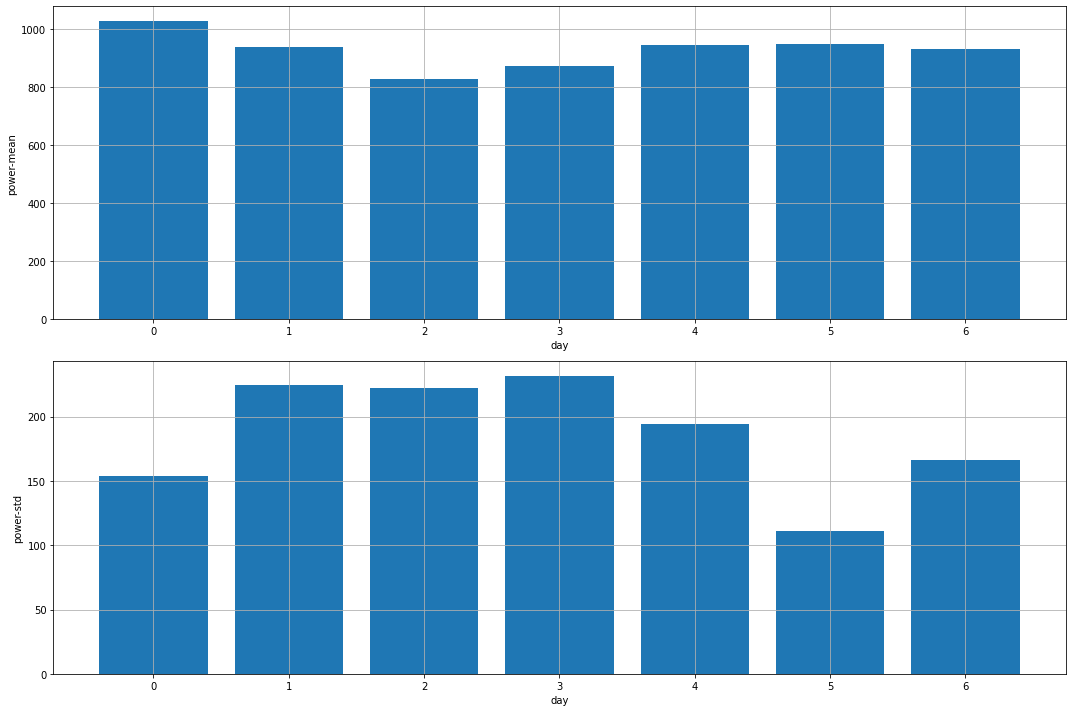

In [13]:
plot_average_power_agg(df, 'day')

#### Średnia moc w godzinach

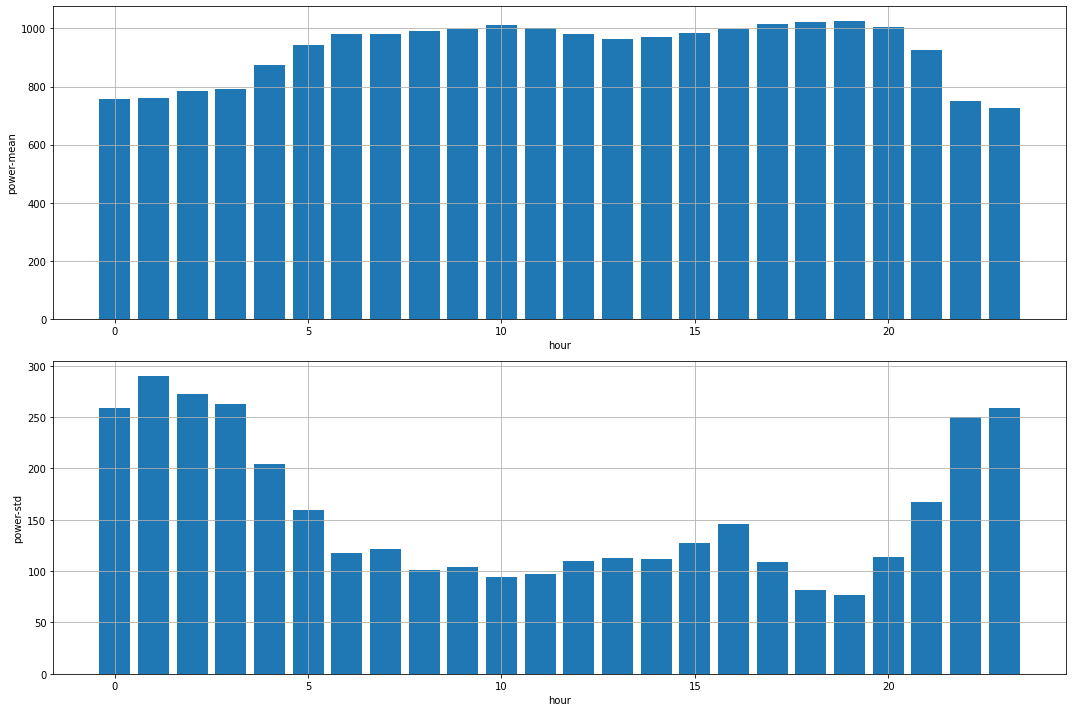

In [14]:
plot_average_power_agg(df, 'hour')

#### Wykres rozkładu zmiennych

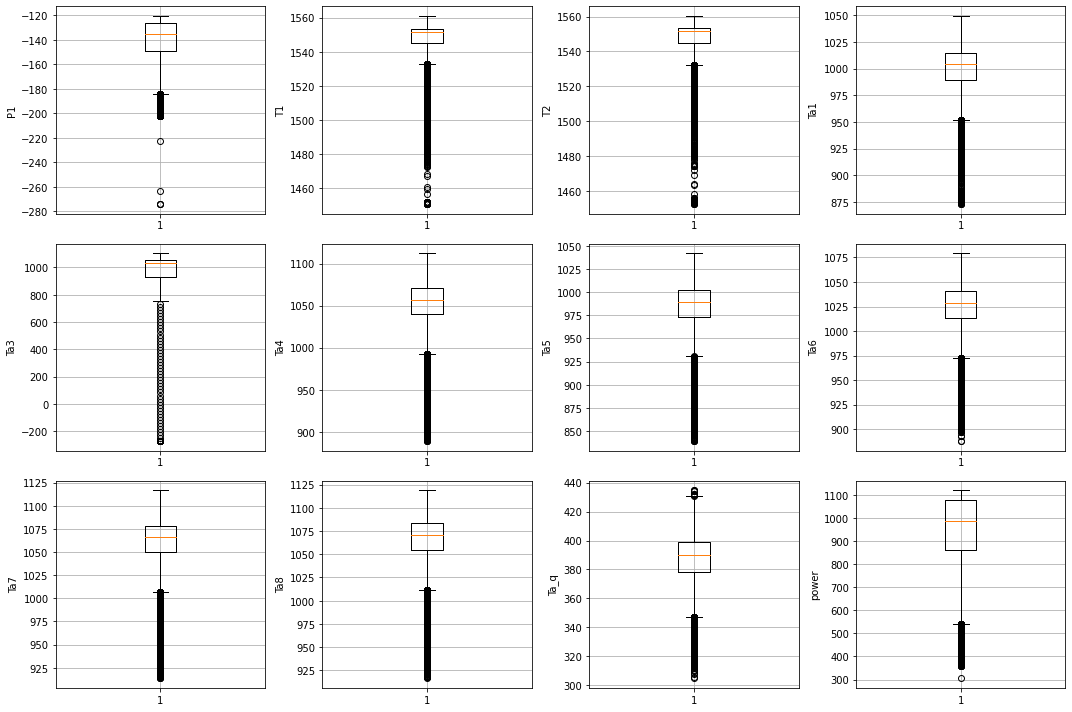

In [15]:
box_plot(df)

#### Wykres rozkładu zmiennych

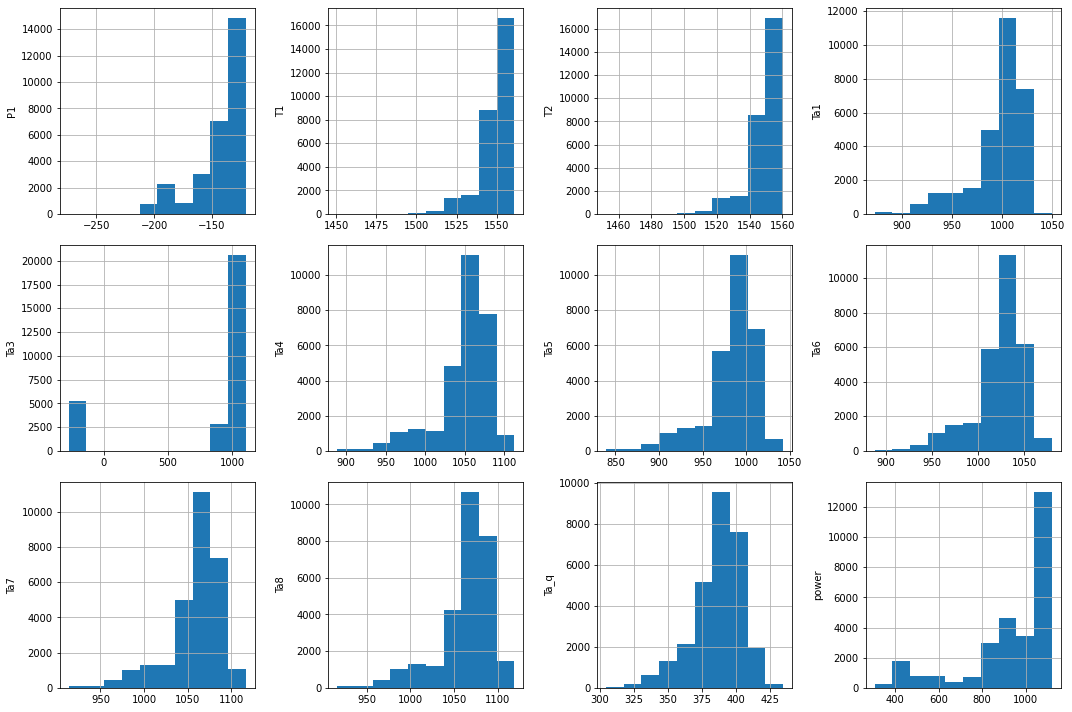

In [16]:
plot_histogram(df)

In [17]:
# Usuniecie Ta3 - pomiary nie obejmują pełnego zakresu.
df = df.drop('Ta3', axis=1)
continuous_columns.remove('Ta3')

#### Moc w odniesieniu do zmiennej kategorycznej

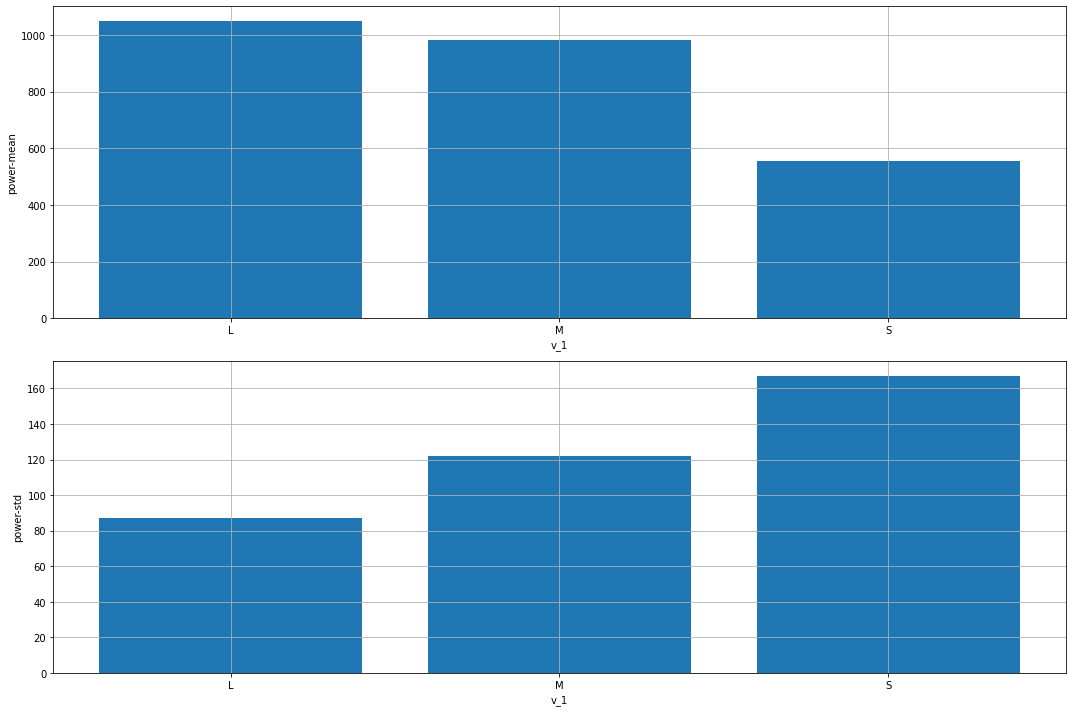

In [18]:
plot_average_power_agg(df, 'v_1')

#### Statystyki danych

In [19]:
df.describe()

,P1,T1,T2,Ta1,Ta4,Ta5,Ta6,Ta7,Ta8,Ta_q,power,hour,day
count,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000
mean,-142.021515,1547.705021,1547.515363,996.960312,1049.365758,983.081076,1022.929628,1059.193442,1063.715860,386.939371,926.907721,11.500000,3.099965
std,21.459929,9.617714,9.594235,26.051422,33.670656,29.694685,27.460002,30.290176,30.566193,18.170094,198.255156,6.922307,1.997561
min,-274.000000,1450.704660,1452.353160,873.047328,888.704590,839.118022,887.755058,913.533281,916.378044,304.668752,305.088220,0.000000,0.000000
25%,-149.233513,1545.234360,1545.023195,989.421804,1039.816323,973.691500,1013.518368,1049.887000,1054.558742,378.322706,861.642230,5.750000,1.000000
50%,-135.128947,1551.740440,1551.534770,1004.094128,1056.418786,989.142523,1028.844722,1065.814897,1070.472336,389.858710,988.192080,11.500000,3.000000
75%,-125.985738,1553.542800,1553.404640,1014.511548,1071.063985,1002.427189,1040.663934,1078.590336,1083.313854,399.282641,1075.986480,17.250000,5.000000
max,-120.431392,1561.094500,1560.400560,1049.356488,1112.636285,1042.309980,1079.600620,1116.866140,1119.095540,434.849707,1120.998380,23.000000,6.000000


                            P1       T1        T2       Ta1      Ta4  \
correlation to power  0.997713  0.72442  0.725078  0.819666  0.78193   

                           Ta5       Ta6       Ta7       Ta8      Ta_q  power  \
correlation to power  0.770053  0.785949  0.779461  0.782849 -0.079976    1.0   

                          hour      day  
correlation to power  0.134567 -0.05397  


None

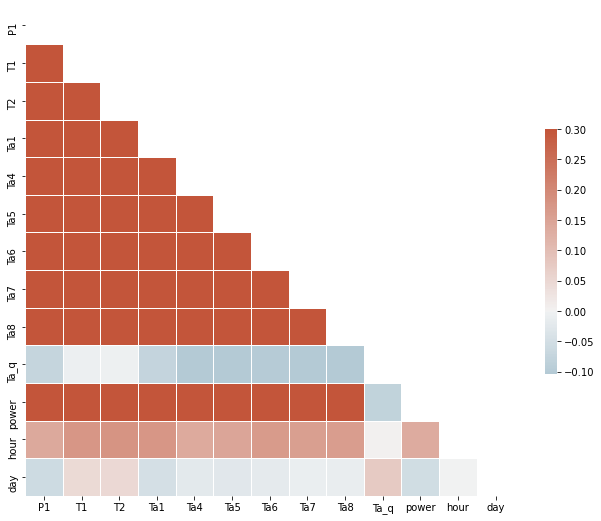

In [20]:
# Srawdzenie korelacji
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
display(print_horizontally(corr['power'], 'correlation to power'))

#### Wykres najbardziej skorelowanej zmiennej

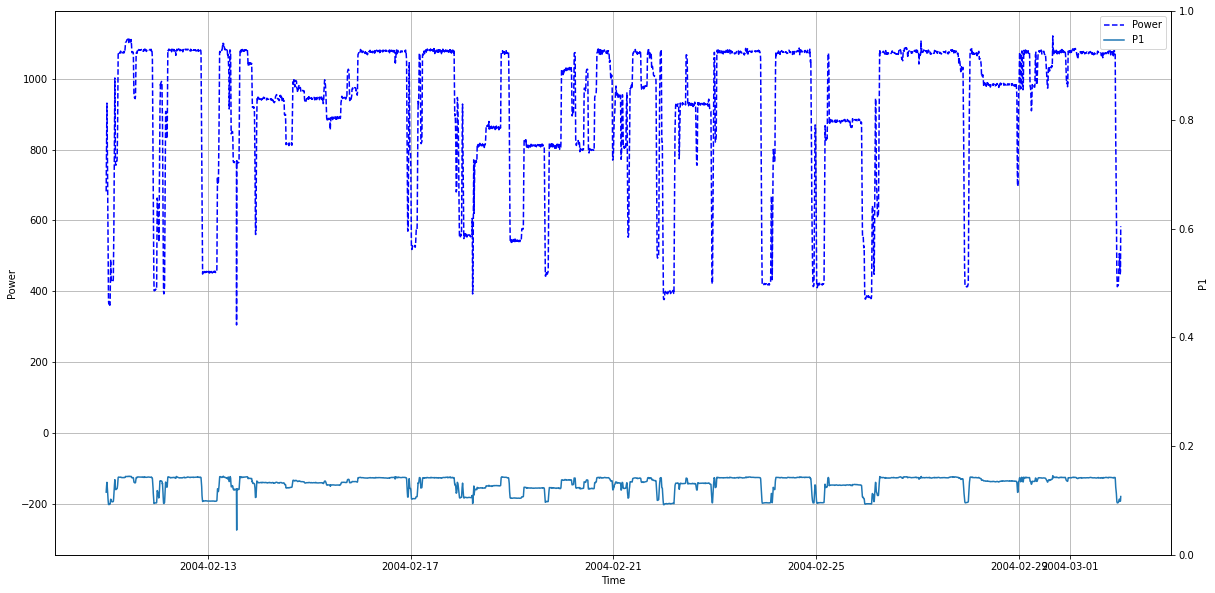

In [21]:
plot_feature_with_power(df, 'P1')

## Wnioski

 * Zmienna 'P1' jest najbrdziej skorelowana ze zmienna objaśnianą
 * Brak widocznego trendu czy sezonowści danych (krótki okres danych)

# Zadanie 2 - Średnia krocząca

In [22]:
# Funckja zwraca tylko columny obliczone. Inny wariant fukcji to 'get_moving_avreage_columns'

In [23]:
def moving_avreage(df: pd.DataFrame, window: int) -> pd.DataFrame:
    moving_avreage_df=df.rolling(window=window).mean()
    new_columns = [f'{col}__{window}__mean' for col in moving_avreage_df.columns]
    moving_avreage_df.columns = new_columns
    moving_avreage_df = moving_avreage_df.dropna()
    
    return moving_avreage_df

# Zadnie 3 - Predyckja

In [24]:
# Stałe
prediction_lenght = 1
test_start = df.index[int(len(df.index)*0.9)]

#### Zdefiniowane dodatkowych kolumns

In [25]:
df = get_lags_columns(df, continuous_columns, 10)
df = get_moving_avreage_columns(df, continuous_columns, [60, 30])
static = pd.get_dummies(df['v_1'], prefix_sep='_',prefix='v_1').astype(int)
df = (df.drop(['v_1'], axis=1)).join(static)
df = df.drop(['hour', 'day'], axis=1)

In [26]:
df['target'] = df['power'].shift(-prediction_lenght)
df = df.dropna()

#### Trening modelu

In [27]:
x_train, x_val, y_train, y_val, x_test, y_test = split_data(df, test_start)
model = XgbModel({})
_ = model.train(x_train, y_train, x_val, y_val)

|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -3.189e+0 |  77.77    |  0.29     |  0.2475   |  23.25    |  24.34    |  0.4628   |
|  2        | -1.272e+0 |  60.9     |  0.7204   |  0.1928   |  17.88    |  1.841    |  0.3388   |
|  3        | -8.64e+04 |  5.851    |  0.7856   |  0.1125   |  16.96    |  7.151    |  0.3781   |
|  4        | -1.15e+03 |  0.9413   |  0.3867   |  0.2848   |  6.794    |  8.665    |  0.8342   |
|  5        | -1.405e+0 |  3.19     |  0.1521   |  0.1893   |  21.22    |  1.209    |  0.6973   |
|  6        | -1.162e+0 |  81.28    |  0.1606   |  0.1973   |  13.2     |  12.52    |  0.8645   |
|  7        | -7.517e+0 |  0.001213 |  0.2976   |  0.214    |  9.141    |  7.648    |  0.6564   |
|  8        | -4.813e+0 |  91.86    |  0.2956   |  0.138    |  7.566    |  10.1     |  0.5836   |
|  9        | -9.366

[40]	validation_0-poisson-nloglik:13.99903	validation_1-poisson-nloglik:15.23394
[41]	validation_0-poisson-nloglik:11.23859	validation_1-poisson-nloglik:12.11638
[42]	validation_0-poisson-nloglik:9.28310	validation_1-poisson-nloglik:9.91534
[43]	validation_0-poisson-nloglik:7.88900	validation_1-poisson-nloglik:8.34617
[44]	validation_0-poisson-nloglik:6.89413	validation_1-poisson-nloglik:7.23276
[45]	validation_0-poisson-nloglik:6.17992	validation_1-poisson-nloglik:6.43149
[46]	validation_0-poisson-nloglik:5.66624	validation_1-poisson-nloglik:5.85609
[47]	validation_0-poisson-nloglik:5.29585	validation_1-poisson-nloglik:5.44327
[48]	validation_0-poisson-nloglik:5.02745	validation_1-poisson-nloglik:5.14249
[49]	validation_0-poisson-nloglik:4.83423	validation_1-poisson-nloglik:4.92618
[50]	validation_0-poisson-nloglik:4.69388	validation_1-poisson-nloglik:4.76845
[51]	validation_0-poisson-nloglik:4.59161	validation_1-poisson-nloglik:4.65403
[52]	validation_0-poisson-nloglik:4.51724	valida

#### Wykres top n istotnych zmiennych

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

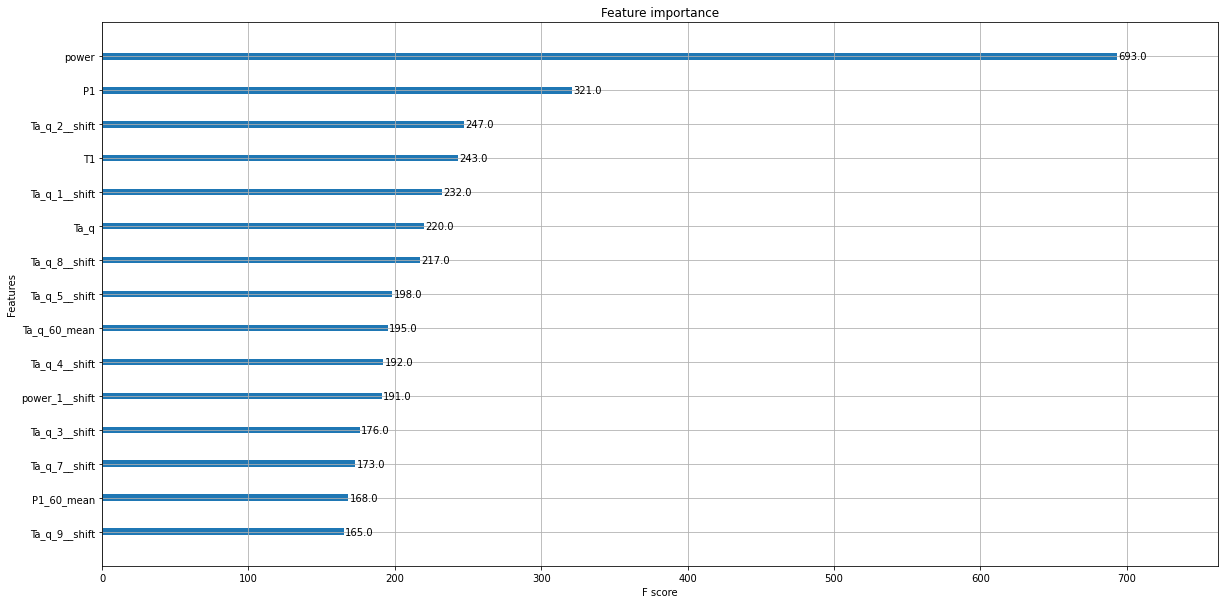

In [28]:
plot_importance_features(model.model, (20,10), 15)

#### Predyckja vs wartości zmierzone

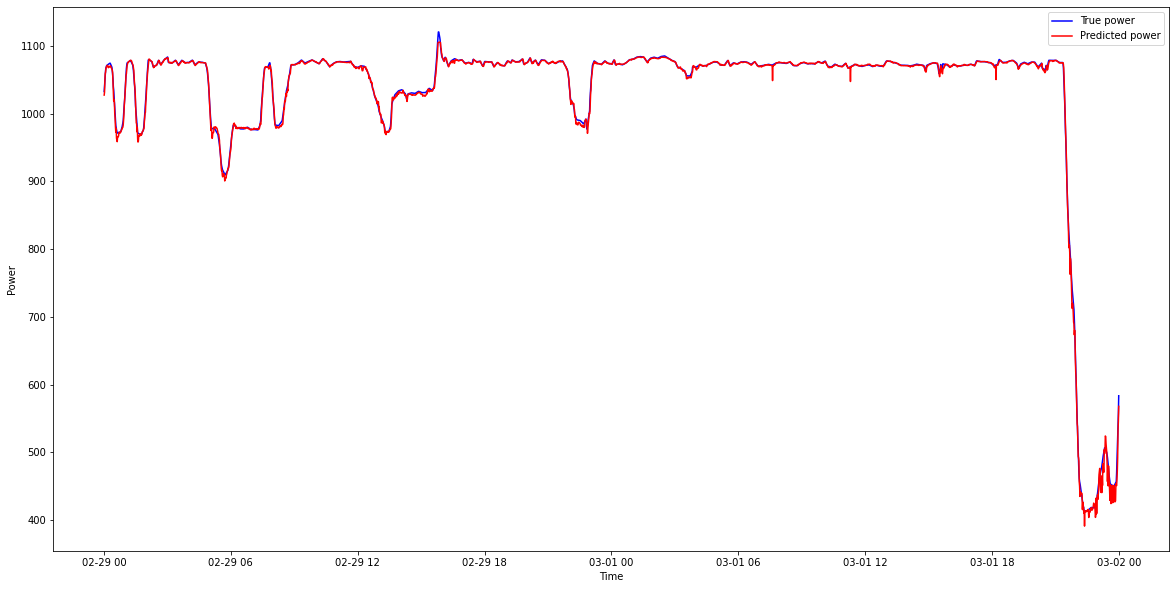

In [29]:
prediction = model.predict(x_test)
plot_prediction(y_test, prediction)

#### Metryki

In [30]:
metrics = calculate_metrics(y_test.target.values, prediction)

MSE:  17.51
MAE:  1.92
R-Squared:  0.999
MAPE:  0.002


# Wnioski

 * Zaprezentowane metryki świadczą o bardzo dobrym dospasowniu modelu. Na tak dobry wynik ma wpływ krótki okres predykcji. 
 * Najbardziej istotny wpływ na doposowanie modelu ma wartość 'power' w chwili t0
 * Przyszłe usprawnienia: Wypróbowanie innych modeli, redukcja zmiennych treningowych, przeprowadznie analizy błedów predykcji, w tym celu można wykorzystać np. narzędzie Lime. 